In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import re
import unidecode
from sklearn.model_selection import KFold

plt.style.use('default')
plt.rcParams['figure.figsize'] = (8,5)

sns.set(style="whitegrid")

pd.options.display.float_format = '{:20,.2f}'.format

import warnings
warnings.filterwarnings('ignore')

In [2]:
tweets = pd.read_csv("../data/train.csv")

In [3]:
tweets["text"] = tweets["text"].str.lower()
tweets["text"] = tweets["text"].apply(lambda x: re.sub('(?P<url>https?://[^\s]+)', ' ', x))
tweets["text"] = tweets["text"].apply(lambda x: re.sub(r'[^\w]', ' ', x))
tweets["text"] = tweets["text"].apply(lambda x: re.sub(r'_', ' ', x))
tweets["text"] = tweets["text"].apply(lambda x: re.sub(r'[0-9]',' ', x))
tweets["text"] = tweets["text"].apply(lambda x: re.sub(' +',' ', x))
tweets["text"] = tweets["text"].apply(lambda x: unidecode.unidecode(x))
tweets["text"] = tweets["text"].str.strip()
tweets["text_length"] = tweets["text"].str.len()
tweets["text"] = tweets["text"].apply(lambda x: re.sub(r'\b\w{1}\b', '', x))
tweets["words_count"] = tweets["text"].str.split(' ').apply(lambda x: len(x))

In [4]:
#tweets.fillna("sin data", inplace=True)  no hace falta reemplazar o quitar los valores nans ya que XGBoost se maneja bien
# con eso
tweets["keyword"] = tweets["keyword"].str.replace('%20',' ')
tweets["keyword"] = tweets["keyword"].astype('category')
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 7 columns):
id             7613 non-null int64
keyword        7552 non-null category
location       5080 non-null object
text           7613 non-null object
target         7613 non-null int64
text_length    7613 non-null int64
words_count    7613 non-null int64
dtypes: category(1), int64(4), object(2)
memory usage: 383.5+ KB


In [5]:
tweets["keyword"].value_counts().nlargest()

fatalities    45
deluge        42
armageddon    42
body bags     41
sinking       41
Name: keyword, dtype: int64

In [7]:
tweets["keyword"].value_counts().nsmallest()

radiation emergency     9
inundation             10
threat                 11
epicentre              12
forest fire            19
Name: keyword, dtype: int64

In [8]:
tweets["keyword"].nunique()

221

### One Hot Encoding

In [9]:
dummies = pd.get_dummies(tweets["keyword"], prefix="keyword")

In [10]:
dummies.head()

,keyword_ablaze,keyword_accident,keyword_aftershock,keyword_airplane accident,keyword_ambulance,keyword_annihilated,keyword_annihilation,keyword_apocalypse,keyword_armageddon,keyword_army,...,keyword_weapons,keyword_whirlwind,keyword_wild fires,keyword_wildfire,keyword_windstorm,keyword_wounded,keyword_wounds,keyword_wreck,keyword_wreckage,keyword_wrecked
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
dummies.columns

Index(['keyword_ablaze', 'keyword_accident', 'keyword_aftershock',
       'keyword_airplane accident', 'keyword_ambulance', 'keyword_annihilated',
       'keyword_annihilation', 'keyword_apocalypse', 'keyword_armageddon',
       'keyword_army',
       ...
       'keyword_weapons', 'keyword_whirlwind', 'keyword_wild fires',
       'keyword_wildfire', 'keyword_windstorm', 'keyword_wounded',
       'keyword_wounds', 'keyword_wreck', 'keyword_wreckage',
       'keyword_wrecked'],
      dtype='object', length=221)

In [11]:
tweets_ohe = pd.concat([tweets,dummies], axis="columns")
tweets_ohe.head()

,id,keyword,location,text,target,text_length,words_count,keyword_ablaze,keyword_accident,keyword_aftershock,...,keyword_weapons,keyword_whirlwind,keyword_wild fires,keyword_wildfire,keyword_windstorm,keyword_wounded,keyword_wounds,keyword_wreck,keyword_wreckage,keyword_wrecked
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1,68,13,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,NaN,NaN,forest fire near la ronge sask canada,1,37,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,130,22,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,NaN,NaN,people receive wildfires evacuation orders in ...,1,56,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1,85,16,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
X = tweets_ohe.drop(["id","keyword","location","text","target"], axis=1)
y = tweets_ohe["target"]

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

In [65]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5709, 223)
(1904, 223)
(5709,)
(1904,)


In [94]:
estimator = LogisticRegression(solver='lbfgs')
selector = RFE(estimator, 100, step=1)   #nos quedamos con las 100 features mas relevantes
selector = selector.fit(X_train, y_train)
# selector = selector.fit(X_train, y_train.ravel())

print(selector.support_)
print(selector.ranking_)

[False False False  True  True  True False False False False  True  True
 False False False False False False False  True False  True  True  True
  True  True False  True  True  True False  True False False  True  True
  True  True False False False  True  True False False False False False
 False False  True False  True False  True  True  True  True False False
 False False False  True  True  True False  True False False False  True
  True False False False False  True False False False  True False  True
  True  True False False  True  True  True False False False False False
  True False  True  True  True False False False  True  True False False
  True False False False False False False  True  True  True  True False
  True  True False False  True False False False False False  True False
 False False False False False False  True False False  True False False
  True False False False False  True False  True  True False  True  True
 False  True  True False  True False False False  T

In [95]:
best_100_features = selector.support_
X.loc[:, best_100_features].head()

,keyword_accident,keyword_aftershock,keyword_airplane accident,keyword_armageddon,keyword_army,keyword_bioterrorism,keyword_blazing,keyword_bleeding,keyword_blew up,keyword_blight,...,keyword_twister,keyword_typhoon,keyword_violent storm,keyword_volcano,keyword_wild fires,keyword_wildfire,keyword_wounded,keyword_wreck,keyword_wreckage,keyword_wrecked
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [96]:
X.loc[:, best_100_features].columns

Index(['keyword_accident', 'keyword_aftershock', 'keyword_airplane accident',
       'keyword_armageddon', 'keyword_army', 'keyword_bioterrorism',
       'keyword_blazing', 'keyword_bleeding', 'keyword_blew up',
       'keyword_blight', 'keyword_blizzard', 'keyword_bloody',
       'keyword_blown up', 'keyword_body bag', 'keyword_body bags',
       'keyword_bombing', 'keyword_bridge collapse',
       'keyword_buildings burning', 'keyword_buildings on fire',
       'keyword_bush fires', 'keyword_casualties', 'keyword_collide',
       'keyword_collision', 'keyword_crashed', 'keyword_crush',
       'keyword_crushed', 'keyword_curfew', 'keyword_deaths', 'keyword_debris',
       'keyword_deluge', 'keyword_demolish', 'keyword_derailed',
       'keyword_derailment', 'keyword_destruction', 'keyword_devastation',
       'keyword_displaced', 'keyword_drought', 'keyword_drown',
       'keyword_dust storm', 'keyword_earthquake', 'keyword_electrocute',
       'keyword_epicentre', 'keyword_evacuated'

In [40]:
#20 features mas relevantes
estimator = LogisticRegression(solver='lbfgs')
selector = RFE(estimator, 20, step=1)
selector = selector.fit(X_train, y_train)

print(selector.support_)
print(selector.ranking_)

[False False False False  True False False False False False False False
 False False False False False False False False False  True False False
 False False False False False False False  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True False False False False False False False
  True False False False False False False False False False False False
  True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False  True False False
 False False False False False  True False False False False  True  True
 False  True False False False False False False  T

In [41]:
best_20_features = selector.support_
X.loc[:, best_20_features].head()

,keyword_aftershock,keyword_blazing,keyword_body bags,keyword_debris,keyword_derailment,keyword_drought,keyword_mass murder,keyword_nuclear disaster,keyword_oil spill,keyword_outbreak,keyword_panic,keyword_razed,keyword_rescuers,keyword_suicide bomb,keyword_suicide bomber,keyword_suicide bombing,keyword_traumatised,keyword_typhoon,keyword_wildfire,keyword_wreckage
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [43]:
X.loc[:, best_20_features].columns

Index(['keyword_aftershock', 'keyword_blazing', 'keyword_body bags',
       'keyword_debris', 'keyword_derailment', 'keyword_drought',
       'keyword_mass murder', 'keyword_nuclear disaster', 'keyword_oil spill',
       'keyword_outbreak', 'keyword_panic', 'keyword_razed',
       'keyword_rescuers', 'keyword_suicide bomb', 'keyword_suicide bomber',
       'keyword_suicide bombing', 'keyword_traumatised', 'keyword_typhoon',
       'keyword_wildfire', 'keyword_wreckage'],
      dtype='object')

In [82]:
#Tomamos las features mas relevantes
estimator = LogisticRegression(solver='lbfgs')
selector = RFE(estimator, 50, step=1)
selector = selector.fit(X_train, y_train)

print(selector.support_)
print(selector.ranking_)

[False False False False  True  True False False False False False False
 False False False False False False False False False  True False  True
  True  True False  True False  True False  True False False  True  True
 False  True False False False False  True False False False False False
 False False  True False False False False False False False False False
 False False False False  True False False  True False False False False
  True False False False False False False False False False False False
  True False False False False False  True False False False False False
 False False  True  True  True False False False False False False False
  True False False False False False False False False False  True False
 False  True False False False False False False False False False False
 False False False False False False False False False  True False False
  True False False False False  True False False False False  True  True
 False  True  True False  True False False False  T

In [83]:
best_50_features = selector.support_
X.loc[:, best_50_features].columns

Index(['keyword_aftershock', 'keyword_airplane accident', 'keyword_blazing',
       'keyword_blew up', 'keyword_blight', 'keyword_blizzard',
       'keyword_bloody', 'keyword_body bag', 'keyword_body bags',
       'keyword_bombing', 'keyword_bridge collapse',
       'keyword_buildings on fire', 'keyword_casualties', 'keyword_collide',
       'keyword_debris', 'keyword_demolish', 'keyword_derailment',
       'keyword_drought', 'keyword_electrocute', 'keyword_evacuated',
       'keyword_evacuation', 'keyword_explode', 'keyword_fear',
       'keyword_forest fires', 'keyword_harm', 'keyword_mass murder',
       'keyword_mayhem', 'keyword_nuclear disaster', 'keyword_oil spill',
       'keyword_outbreak', 'keyword_panic', 'keyword_panicking',
       'keyword_quarantine', 'keyword_razed', 'keyword_rescuers',
       'keyword_ruin', 'keyword_screaming', 'keyword_sinking', 'keyword_smoke',
       'keyword_stretcher', 'keyword_suicide bomb', 'keyword_suicide bomber',
       'keyword_suicide bombi

In [97]:
X_reduced = X.loc[:, best_100_features]
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.25, random_state=100)

#### Ajustando hiper-parametros (usando todos los features(223)):
    - n_estimators=10, max_depth=6, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8
    SCORE 0.646534
    - n_estimators=10, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8
    SCORE 0.660714
    - n_estimators=20, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8
    SCORE 0.668592
    - n_estimators=20, max_depth=7, learning_rate=0.1, subsample=1, colsample_bytree=0.7
    SCORE 0.670693
    - n_estimators=20, max_depth=9, learning_rate=0.1, subsample=1, colsample_bytree=0.7
    SCORE 0.673319
    - n_estimators=20, max_depth=11, learning_rate=0.1, subsample=1, colsample_bytree=0.7
    SCORE 0.677521
    - n_estimators=50, max_depth=7, learning_rate=0.1, subsample=1, colsample_bytree=0.5
    SCORE 0.686450
    - n_estimators=50, max_depth=9, learning_rate=0.1, subsample=1, colsample_bytree=0.5
    SCORE 0.701155
    - n_estimators=50, max_depth=11, learning_rate=0.1, subsample=1, colsample_bytree=0.5
    SCORE 0.703782
    - n_estimators=50, max_depth=13, learning_rate=0.1, subsample=1, colsample_bytree=0.5
    SCORE 0.711660
    - n_estimators=50, max_depth=15, learning_rate=0.1, subsample=1, colsample_bytree=0.5
    SCORE 0.716387
    - n_estimators=100, max_depth=9, learning_rate=0.1, subsample=1, colsample_bytree=0.5
    SCORE 0.724790
    - n_estimators=100, max_depth=9, learning_rate=0.1, subsample=1, colsample_bytree=0.5
    SCORE 0.724790
    - n_estimators=200, max_depth=11, learning_rate=0.1, subsample=1, colsample_bytree=0.5
    SCORE 0.733193
    - n_estimators=200, max_depth=13, learning_rate=0.1, subsample=1, colsample_bytree=0.5
    SCORE 0.734244
    - n_estimators=300, max_depth=11, learning_rate=0.1, subsample=1, colsample_bytree=0.5
    SCORE 0.740546
    - n_estimators=300, max_depth=11, learning_rate=0.1, subsample=1, colsample_bytree=0.3
    SCORE 0.740021
    - Mejor SCORE: 0.740546
    
#### Ajustando hiper-parametros (100 features):
    - n_estimators=50, max_depth=7, learning_rate=0.1, subsample=1, colsample_bytree=0.5
    SCORE 0.669643
    - n_estimators=50, max_depth=11, learning_rate=0.1, subsample=1, colsample_bytree=0.5
    SCORE 0.682773
    - n_estimators=50, max_depth=15, learning_rate=0.1, subsample=1, colsample_bytree=0.7
    SCORE 0.707983
    - n_estimators=50, max_depth=15, learning_rate=0.1, subsample=1, colsample_bytree=0.7
    SCORE 0.713761
    - Mejor SCORE: 0.713761
    
#### Ajustando hiper-parametros (50 features):
    - n_estimators=50, max_depth=7, learning_rate=0.1, subsample=1, colsample_bytree=0.3
    SCORE 0.668067
    - Mejor SCORE: 0.668067

#### Ajustando hiper-parametros (30 features):
    - n_estimators=10, max_depth=9, learning_rate=0.1, subsample=1, colsample_bytree=0.5
    SCORE 0.652836
    - n_estimators=20, max_depth=11, learning_rate=0.1, subsample=1, colsample_bytree=0.5
    SCORE 0.658613
    - n_estimators=100, max_depth=11, learning_rate=0.1, subsample=1, colsample_bytree=0.5
    SCORE 0.658613
    - n_estimators=500, max_depth=13, learning_rate=0.1, subsample=1, colsample_bytree=0.5
    SCORE 0.658613
    - Mejor SCORE: 0.658613
    
#### Ajustando hiper-parametros (10 features):
    - Mejor SCORE: 0.619748

In [119]:
model_xgb = xgb.XGBClassifier(n_estimators=50, objective='binary:logistic', max_depth=21, learning_rate=0.1,
                          subsample=1, colsample_bytree=0.5, alpha=0.1, n_jobs=1)
model_xgb.fit(X_train, y_train)

XGBClassifier(alpha=0.1, base_score=0.5, booster='gbtree',
       colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
       gamma=0, gpu_id=-1, importance_type='gain',
       interaction_constraints='', learning_rate=0.1, max_delta_step=0,
       max_depth=21, min_child_weight=1, missing=nan,
       monotone_constraints='()', n_estimators=50, n_jobs=1,
       num_parallel_tree=1, objective='binary:logistic', random_state=0,
       reg_alpha=0.100000001, reg_lambda=1, scale_pos_weight=1,
       subsample=1, tree_method='exact', validate_parameters=1,
       verbosity=None)

In [120]:
y_test_hat = model_xgb.predict(X_test)
print("Accuracy score: %f" % (accuracy_score(y_test, y_test_hat)))

Accuracy score: 0.713761


In [121]:
model_xgb.score(X_test, y_test)*100

71.37605042016807

In [255]:
#Convertimos los datos a DMatrix
data_dmatrix = xgb.DMatrix(data=X.loc[:, best_20_features], label=y)
parametros = {'objective':'binary:logistic','colsample_bytree':0.5, 'learning_rate':0.1, 'max_depth':11}

cv_results = xgb.cv(dtrain=data_dmatrix, params=parametros, nfold=3, num_boost_round=50, early_stopping_rounds=10,\
                   metrics='error', as_pandas=True, seed=100)

In [256]:
cv_results.head()

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.40,0.00,0.40,0.01
1,0.38,0.01,0.38,0.01
2,0.37,0.00,0.37,0.01
3,0.37,0.00,0.37,0.01
4,0.37,0.00,0.37,0.01


In [257]:
cv_results["test-error-mean"].tail(1)

14                   0.37
Name: test-error-mean, dtype: float64

In [258]:
#Visualizamos los arboles
xgb_clasif = xgb.train(params=parametros, dtrain=data_dmatrix, num_boost_round=10)

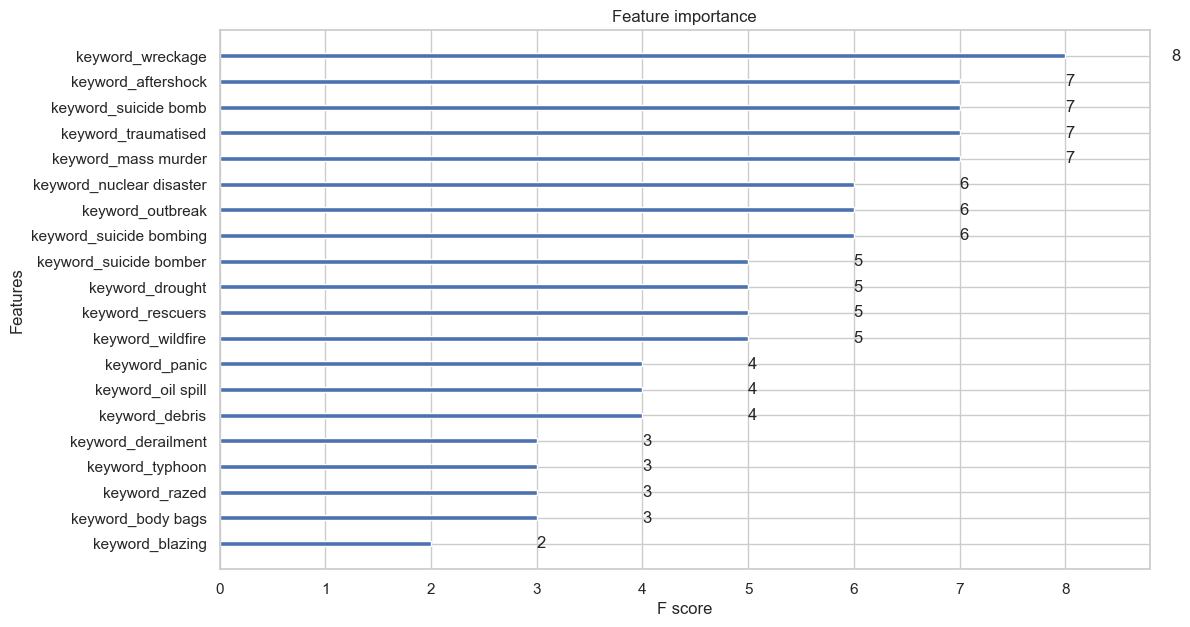

In [259]:
#Importancia de los features (cuantes veces aparecen en los arboles)
plt.rcParams['figure.figsize'] = [12,7]
xgb.plot_importance(xgb_clasif)

#### XGBoost - mejor resultado: 0.740546